In [1]:
%matplotlib inline

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

(720, 1280)


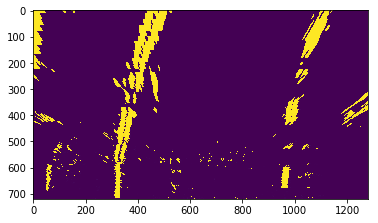

In [2]:
binary_warped = mpimg.imread('calibration_wide/warped-example.jpg')

print(binary_warped.shape)
plt.imshow(binary_warped)

360


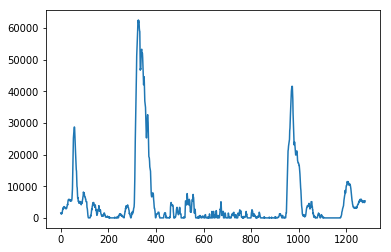

In [3]:
# 画像下半分のヒストグラム
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

print(binary_warped.shape[0]//2)
plt.plot(histogram)

(720, 1280, 3)


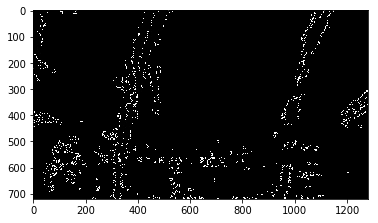

In [4]:
img = np.dstack((binary_warped, binary_warped, binary_warped))*255

print(img.shape)
plt.imshow(img)

In [5]:
midpoint = np.int(histogram.shape[0]//2)

# ヒストグラムの2つのピーク値を探す
# NumPyのargmax関数は、多次元配列の中の最大値の要素を持つインデックスを返す関数
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

print(midpoint, leftx_base, rightx_base)

640 327 971


In [6]:
# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]//nwindows)

print(window_height)

80


In [7]:
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# nonzero関数は非ゼロ要素の抽出
print(nonzeroy, nonzerox)
print(binary_warped[0, 0], binary_warped[0, 1], binary_warped[0, 2])

[  0   0   0 ... 719 719 719] [   0    1    2 ... 1051 1067 1069]
255 255 255


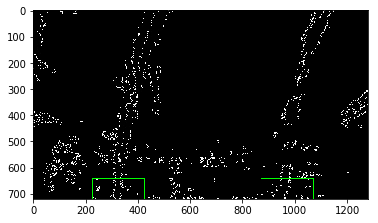

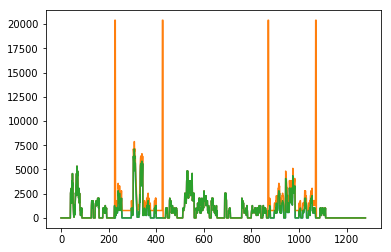

0 result: 319 968



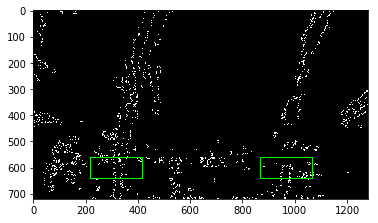

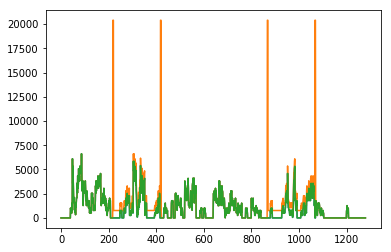

1 result: 327 989



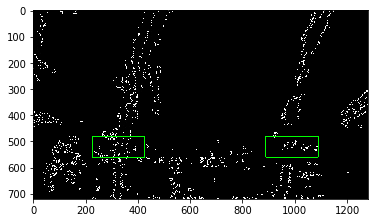

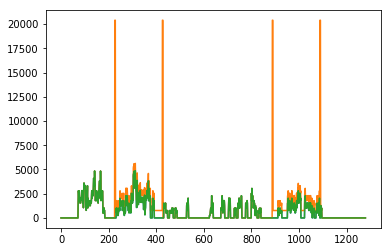

2 result: 329 1002



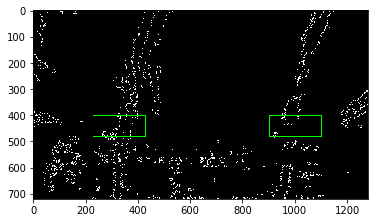

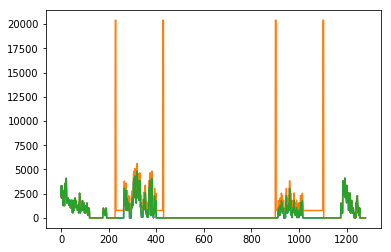

3 result: 344 977



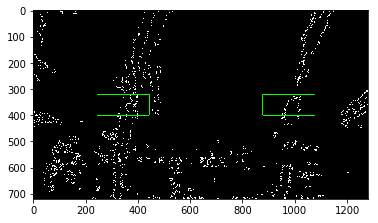

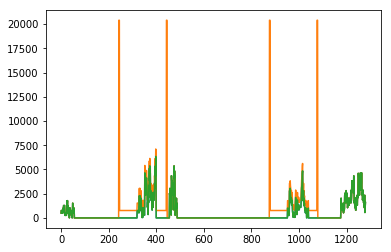

4 result: 366 992



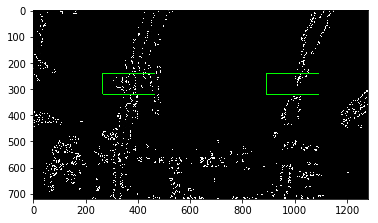

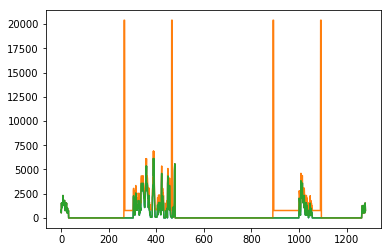

5 result: 391 1021



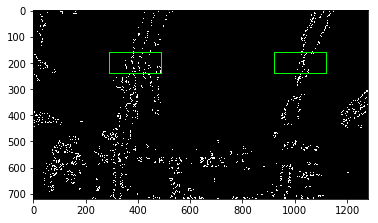

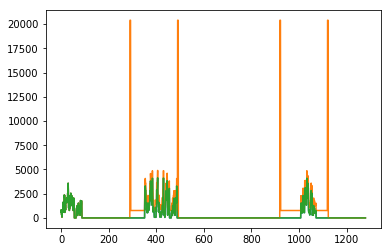

6 result: 411 1036



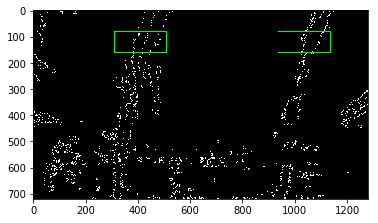

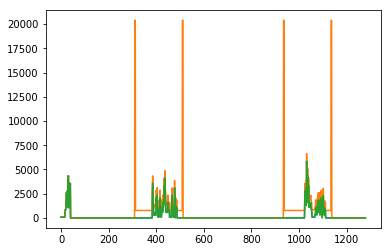

7 result: 432 1063



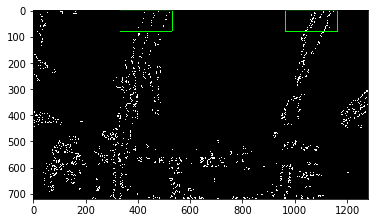

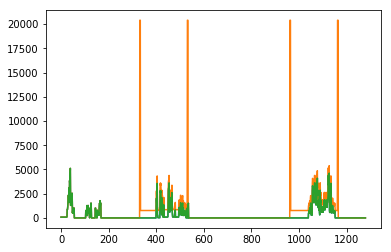

8 result: 462 1097

left a,b,c [ 2.23090058e-04 -3.90812851e-01  4.78139852e+02]
right a,b,c [ 4.19709859e-04 -4.79568379e-01  1.11522544e+03]


In [8]:
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Smarginet the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Draw the windows on the visualization image
    out_img = img.copy()
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
    
    # 現在の探索範囲 (下から探索)
    plt.figure() 
    plt.imshow(out_img)
    plt.show()
    
    # 窓高さ内のヒストグラム
    histogram = np.sum(out_img[win_y_low:win_y_high,:], axis=0)
    plt.plot(histogram)
    plt.show()
    
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    
    # Append these indices to the lists
    # 探索領域内の有効要素を後のフィッティングのために貯めこんでいく
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # If you found > minpix pixels, recenter next window on their mean position
    # 窓内で発見した左右の車線位置
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    print(window, "result:", leftx_current, rightx_current)
    print("")
    
# Concatenate the arrays of indices
# 配列の連結
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to eachnonzerox
# 二次関数でフィッティング
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

print("left a,b,c", left_fit)
print("right a,b,c", right_fit)

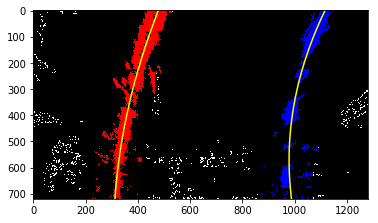

In [9]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.figure() 
img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(img)

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
# plt.xlim(0, 1280)
# plt.ylim(720, 0)

plt.show()

In [10]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100

left_lane_inds_width_limit = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                                left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                                left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds_width_limit = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                                right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                                right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds_width_limit]
lefty = nonzeroy[left_lane_inds_width_limit] 
rightx = nonzerox[right_lane_inds_width_limit]
righty = nonzeroy[right_lane_inds_width_limit]

# Fit a second order polynomial to each
# 二次関数で再フィッティング
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

print("left a,b,c", left_fit)
print("right a,b,c", right_fit)

left a,b,c [ 1.57054697e-04 -3.47011052e-01  4.75912934e+02]
right a,b,c [ 4.34665454e-04 -4.88797399e-01  1.11592368e+03]


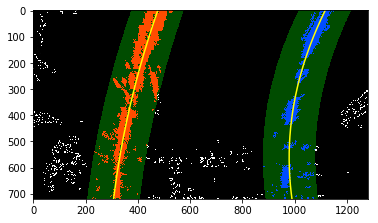

In [11]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds_width_limit], nonzerox[left_lane_inds_width_limit]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds_width_limit], nonzerox[right_lane_inds_width_limit]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
# plt.xlim(0, 1280)
# plt.ylim(720, 0)

plt.show()